# Oscillation detection methods
### Setup
These are relatively new methods, so we'll have to install packages specifically dedicated to them. We'll get into the methods and what they do shortly.

**Remember to activate the appropriate conda environment before installing** <br>

First, let's install FOOOF:

```pip install fooof```

Next, let's clone and install IRASA:

```cd ~``` <br>
```git clone https://github.com/jrudoler/irasa``` <br>
```pip install -e ~/irasa/``` <br>


Before we get started, I think it's appropriate to shoutout Tom Donoghue for developing a seriously awesome toolbox for his own method of oscillation detection, FOOOF, along with some associated educations materials / tutorials that I'll be leaning on (read: totally ripping off) for parts of this interactive session.

Check it out here: https://fooof-tools.github.io/fooof/index.html

In [1]:
from irasa.IRASA import IRASA
import fooof
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from CMLLoad import CMLLoad
from fooof import FOOOF
from fooof.bands import Bands
from fooof.utils import trim_spectrum
from fooof.sim.gen import gen_power_spectrum
from fooof.plts.spectra import plot_spectra_shading
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate import plot_annotated_model
plt.style.use('seaborn-whitegrid')

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

## Motivation

In earlier notebooks we covered spectral analysis - the approach of decomposing a timeseries into its **rhythmic components**. The idea is that brain waves - in a very literal sense - at specific frequencies are increasing or decreasing in amplitude, and that this is related to cognition. We hope that these patterns - a representation of synchronized neural activity - will help us decipher and predict what the brain is doing.

But... what if that's too simplistic? The power spectrum changes in complex ways that are not necessarily consistent with this idea that changes in power reflect a synchronization of activity unique to a specific frequency band.

We already learned about the $1/f$ background spectrum, which is present under all conditions - studies have even shown it's present during minimally conscious or vegatative states! Well, this background spans the entire frequency spectrum in a way that really is not consistent with our assumed model of narrow, independent frequency bands that change with behavior in unique and predictable ways. 

For that reason, the background spectrum is referred to as the **aperiodic** component of the EEG trace, while narrow-band oscillations are the **periodic** component.

**Note**: *Since this background follows a power law distribution, it's also often referred to by other names which refer to this distribution. So when you hear background, $1/f$, pink noise, power law distribution, fractal, or aperiodic - just know that while these have slightly different connotations, they all refer to the same phenomenon in the context of EEG analyses.*

### Stochasticity, noise, and the need for robust estimations

![](https://raw.githubusercontent.com/OscillationMethods/Visualizers/main/gifs/fig1.gif)

The above figure shows pure pink noise - it's random data with a $1/f$ shape. As you can see, our estimation of power in different frequency bands fluctuates quite a bit over time.

### A Better Oscillation Detection Method (BOSC)
Here's the idea:
We want to robustly determine the extent to which oscillations at frequencies of interest are present in a given time interval, so that we are not thrown off by outliers and transient signals. To that end, we will compute a metric $P_{episode}$ - the proportion of a time window that is deemed to be oscillatory. The unique advantage of BOSC is that we explicitly consider the time domain, and not *only* the frequency domain. The criteria for an oscillation are:
1. **Amplitude**: Power at the given frequency exceeds a power threshold determined from the $\chi^2$ distribution of powers based on a fit to the background spectrum. So, the threshold we set is testing the oscillation's *deviation* from the background instead of naively considering raw power. 
2. **Duration**: Power at the given frequency exceeds the aforementioned power threshold for *at least* 3 cycles of the given frequency. So, a 1 Hz oscillation (1 cycle per second) must last for 3 seconds or more to be considered a true oscillation.

![](https://ars.els-cdn.com/content/image/1-s2.0-S1053811910011614-gr1.jpg)

BOSC does a somewhat poor job of actually fitting the background spectrum and setting this threshold. But, it's on the right track, and is very important conceptually!

### Changing parameters, changing spectra

![Alt Text](./materials/exp_animation.gif)
**Side note**: This animation was generated with fewer than 40 lines of python code! Look into ```matplotlib.animation``` if you're interested in making some cool dynamic data visualizations

Once we begin to consider our neural signal as a superposition of an aperiodic background spectrum and a periodic components (oscillations), we can think about how some parameters in our data might vary. We might observe:

- a change in the **power** of the periodic component
- a change in **center frequency** of the periodic component
- a change in the **offset** of the aperiodic component
- a change in the **exponent** of the aperiodic component

In the visualization below, which is generated from simulated data, we can see that we have created four sets of comparisons, where each has a change in one parameter of the data.

In [2]:
# Define our bands of interest
bands = Bands({'alpha' : (8, 12)})

# Simulation Settings
nlv = 0
f_res = 0.1
f_range = [3, 35]

# Define baseline parameter values
ap_base = [0, 1.5]
pe_base = [[10, 0.5, 1], [22, 0.2, 2]]

# Define parameters sets with changes in each parameter
pw_diff = [[10, 0.311, 1], [22, 0.2, 2]]
cf_diff = [[11.75, 0.5, 1], [22, 0.2, 2]]
off_diff = [-0.126, 1.5]
exp_diff = [-0.87, 0.75]

# Create baseline power spectrum, to compare to
freqs, powers_base = gen_power_spectrum(f_range, ap_base, pe_base, nlv, f_res)

# Create comparison power spectra, with differences in different parameters of the data
_, powers_pw = gen_power_spectrum(f_range, ap_base, pw_diff, nlv, f_res)
_, powers_cf = gen_power_spectrum(f_range, ap_base, cf_diff, nlv, f_res)
_, powers_off = gen_power_spectrum(f_range, off_diff, pe_base, nlv, f_res)
_, powers_exp = gen_power_spectrum(f_range, exp_diff, pe_base, nlv, f_res)

# Collect the comparison power spectra together
all_powers = {
    'Alpha Power Change' : powers_pw,
    'Alpha Frequency Change' : powers_cf,
    'Offset Change' : powers_off,
    'Exponent Change' : powers_exp
}

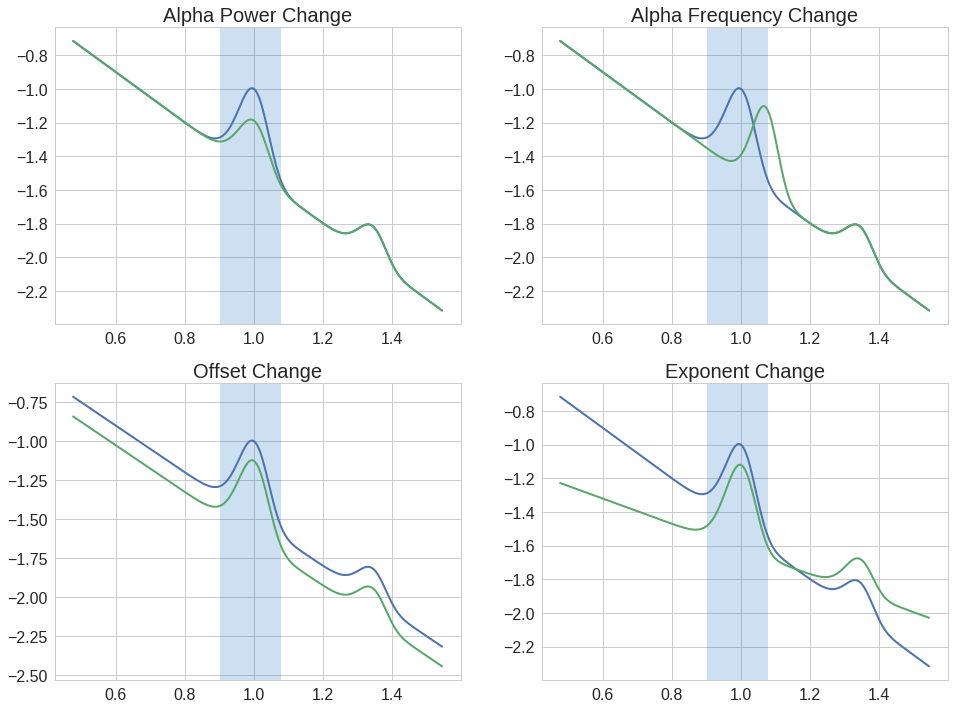

In [3]:
# Plot and compare all of our power spectra
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
log_freqs = True
log_powers = True
shade_color = '#0365C0'
for ax, (title, powers) in zip(axes.reshape(-1), all_powers.items()):

    # Create spectrum plot, with alpha band of interest shaded in
    plot_spectra_shading(freqs, [powers_base, powers],
                         bands.alpha, shade_colors=shade_color,
                         log_freqs=log_freqs, log_powers=log_powers, ax=ax)

    # Add the title, and do some plot styling
    ax.set_title(title, {'fontsize' : 20})
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

#### Different spectra, but the same statistical story

We can compare our different power spectra, in terms of band-specific power measures.

Then, for each pair, consisting of the baseline power spectrum and an adapted version
in which one parameter has been changed, we can measure the change in band specific
activity relating to this change.

In [4]:
def calc_avg_power(freqs, powers, freq_range):
    """Helper function to calculate average power in a band."""

    _, band_powers = trim_spectrum(freqs, powers, freq_range)
    avg_power = np.mean(band_powers)

    return avg_power

# Calculate the amount of alpha power in the baseline power spectrum
base_alpha = calc_avg_power(freqs, powers_base, bands.alpha)

# Calculate the different in alpha power for each of our comparison pairs
for title, powers in all_powers.items():
    print('{:20s}\t {:1.4f}'.format(\
        title, calc_avg_power(freqs, powers, bands.alpha) - base_alpha))

Alpha Power Change  	 -0.0171
Alpha Frequency Change	 -0.0171
Offset Change       	 -0.0171
Exponent Change     	 -0.0171


We can see that **all of these cases have the exact measured change in alpha power!**

However, given that we know exactly what was changed in the simulated data, we know
that **a change in alpha power is only the correct interpretation in one of the cases**
that we simulated.

For all the other comparisons, the change in the data is not a change in band specific
power. Despite this, the common analysis approach measures it as such.

This shows how measurements that are supposed to reflect band specific power changes
can easily be conflated and misinterpreted, as they can be driven by other changes
in the data.




#### Load Data

In [5]:
load = CMLLoad('./CMLExamples')
df = load.Index()
sub = 'R1111M'
exp = 'FR1'
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
df_sess = df_select.iloc[0]

evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']
rec_mask = word_evs.recalled.values.astype(bool)

eeg_ptsa = load.LoadPTSA(df_sess, ev_start=0, ev_len=1600)
# select word events, first 5 channels
eeg = eeg_ptsa[word_evs.index, 63]

## Fitting Oscillations & One Over F (FOOOF)

In [6]:
# Set random seed, for consistency generating simulated data
set_random_seed(21)

# Simulate example power spectra
freqs1, powers1 = gen_power_spectrum([3, 40], [1, 1],
                                     [[10, 0.2, 1.25], [30, 0.15, 2]])

# Initialize power spectrum model objects and fit the power spectra
fm1 = FOOOF(min_peak_height=0.05, verbose=False)
fm1.fit(freqs1, powers1)

Plotted below is an example power spectrum, plotted in semi-log space (log10 power values
and linear frequencies). This is our data, that we will be trying to model.

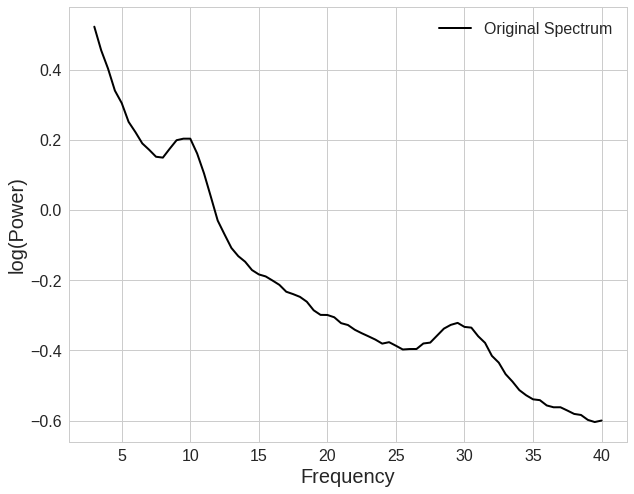

In [7]:
# Plot one of the example power spectra
plot_spectrum(freqs1, powers1, log_powers=True,
              color='black', label='Original Spectrum')

### Periodic Component

In the frequency domain, putative oscillations are frequency regions in which
there are 'bumps' of power over and above the aperiodic component.
We will generally refer to the these as 'peaks' in the neural power spectrum.

To measure the periodic activity, we would like to describe these peaks, without our
measures of these peaks being influenced by co-occurring aperiodic activity.
This is important, since, as we can see in the plots above, the aperiodic and periodic
components of the data can 'overlap', in frequency space. This means the total power
at a given frequency may have contributions from both components. To measure periodic power,
specifically, we need to measure the power relative to the aperiodic component of the data.

Next, let's explore an annotated version of our power spectrum model.




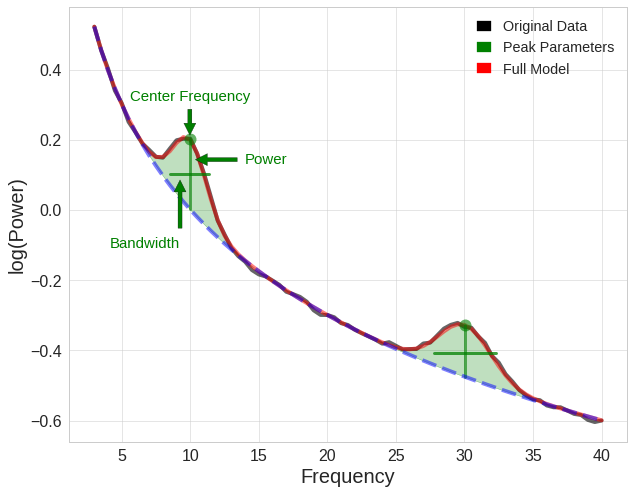

In [8]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm1, annotate_aperiodic=False)

In the labeled plot above, we can again see the different components of the model,
as well as the labeled peak parameters.

Note that vertical labels reflect parameters measured in the x-axis units, so in frequency,
where as horizontal labels reflect parameters measured in y-axis units, so power.

The periodic parameters are:

- the `center frequency` of the peak, in units of frequency
- the `power` of the peak, over the aperiodic component, in units of power
- the `bandwidth`, or the width of the peak, in units of frequency

Wherever we detect a peak, these are the parameters that we will fit to the peak,
to describe this component of the data.




#### Mathematical Description of the Periodic Component

To fit this periodic activity - the regions of power over above the aperiodic component,
or 'peaks' - the model uses Gaussians. As we've seen, there can be multiple peaks in the model.

Each Gaussian, $n$, referred to as $G(F)_n$, is of the form:

\begin{align}G(F)_n = a * exp (\frac{- (F - c)^2}{2 * w^2})\end{align}

This describes each peak in terms of parameters `a`, `c` and `w`, where:

- $a$ is the height of the peak, over and above the aperiodic component
- $c$ is the center frequency of the peak
- $w$ is the width of the peak
- $F$ is the array of frequency values

### Aperiodic Component

By 'aperiodic' activity, we mean activity that is not rhythmic, or activity that has
no characteristic frequency.

In the power spectrum, we typically see this as 1/f-like activity, whereby (in linear space)
the power across frequencies decreases with a $\frac{1}{F^\chi}$ relationship.

To measure the aperiodic activity, we would like to describe the pattern of activity
across all frequencies, without our measure being influenced by co-occurring periodic
activity (peaks).




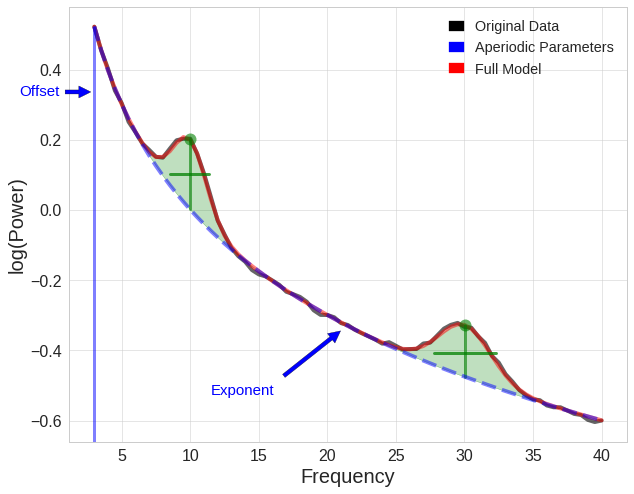

In [9]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm1, annotate_peaks=False)

The aperiodic parameters in the above plot are:

- the `offset`, or overall up/down translation of the whole spectrum
- the `exponent`, which describes the 'curve', or overall 'line' of the aperiodic component

Note that diagonal labels indicate unit-less measures (in neither units of frequency or power).




#### Mathematical Description of the Aperiodic Component

To fit the aperiodic component, we will use the function $L$:

\begin{align}L(F) = b - \log(k + F^\chi)\end{align}

Note that this function is fit on the semi-log power spectrum, meaning linear frequencies
and $log_{10}$ power values.

In this formulation, the parameters $b$, $k$, and $\chi$
define the aperiodic component, as:

- $b$ is the broadband 'offset'
- $k$ is the 'knee'
- $\chi$ is the 'exponent' of the aperiodic fit
- $F$ is the array of frequency values

Note that fitting the knee parameter is optional. If used, the knee parameter defines a
'bend' in the aperiodic `1/f` like component of the data. If not used, the 'knee'
parameter is set to zero.

This function form is technically described as a Lorentzian function. We use the option
of adding a knee parameter, since even though neural data is often discussed in terms
of having `1/f` activity, there is often not a single `1/f` characteristic, especially
across broader frequency ranges. Therefore, using this function form allows for modeling
bends in the power spectrum of the aperiodic component, if and when they occur.

Note that if we were to want the equivalent function in linear power, using $AP$
to indicate the aperiodic component in linear spacing, it would be:

\begin{align}AP(F) = 10^b * \frac{1}{(k + F^\chi)}\end{align}




Conclusion
----------

So far, we have explored how neural power spectra, $NPS$, across a set of frequencies
$F$ can be modeled as a combination of an aperiodic component, $L$, and the
periodic component, which is comprised of `N` peaks, where each $G_n$ is a Gaussian.

To summarize, the full model is:

\begin{align}NPS(F) = L(F) + G(F)_n\end{align}

where:

\begin{align}L(F) = b - \log(k + F^\chi) \quad \quad G(F)_n = a * exp (\frac{- (F - c)^2}{2 * w^2})\end{align}

This approach allows us to measure periodic and aperiodic activity from neural
power spectra, and describe them with model parameters:

- $b$, $k$, and $\chi$ of the aperiodic component which reflect
  the `offset`, `knee` and `exponent`, respectively
- $c$, $a$, $w$ for each periodic peak, relating to the
  `center frequency`, `power` and `bandwidth` of putative periodic activity

FOOOF Fitting Algorithm
-----------------------
Broadly, the steps in the algorithm are:

1. An initial fit of the aperiodic component is computed from the power spectrum
2. This aperiodic fit is subtracted from the power spectrum, creating a flattened spectrum
3. An iterative process identifies peaks in this flattened spectrum
4. A full peak fit is re-fit from all of the identified peak candidates
5. The peak fit is subtracted from the original power spectrum,
     creating a peak-removed power spectrum
6. A final fit of the aperiodic component is taken of the peak-removed power spectrum
7. The full model is reconstructed from the combination of the aperiodic and peak fits,
     and goodness of fit metrics are calculated.

For a detailed tutorial see: https://fooof-tools.github.io/fooof/auto_tutorials/plot_03-FOOOFAlgorithm.html#sphx-glr-auto-tutorials-plot-03-fooofalgorithm-py


### Back to real data

In [10]:
# Initialize a FOOOF object, with some settings
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.05)

Note that data can be added to a FOOOF object independent of fitting the model, using the
:meth:`~fooof.FOOOF.add_data` method. FOOOF objects can also be used to plot data,
prior to fitting any models.




In [11]:
from ptsa.data.filters import MorletWaveletFilter
eeg.add_mirror_buffer(.5)
pows, _ = MorletWaveletFilter(freqs).filter(eeg)
pows.remove_buffer(.5)
spectrum = pows.mean(['event', 'time']).values

TraitError: The 'freqs' trait of a MorletWaveletFilter instance must be an array, but a value of <xarray.TimeSeries (event: 288, time: 800)>
array([[-1346., -1347., -1356., ..., -1589., -1592., -1593.],
       [-1336., -1339., -1347., ..., -1101., -1110., -1129.],
       [-1270., -1270., -1265., ..., -1308., -1325., -1350.],
       ...,
       [-1502., -1503., -1500., ..., -1329., -1341., -1352.],
       [-1514., -1489., -1464., ..., -1134., -1130., -1131.],
       [-1539., -1532., -1531., ..., -1256., -1254., -1255.]])
Coordinates:
    channel     <U13 'LPOG34-LPOG42'
  * time        (time) float64 0.0 2.0 4.0 6.0 ... 1.594e+03 1.596e+03 1.598e+03
  * event       (event) object {'Index': 27, 'eegoffset': 100520, 'answer': -...
    samplerate  float64 500.0 <class 'ptsa.data.timeseries.TimeSeries'> was specified.

In [202]:
# Add data to the object
fm.add_data(freqs=freqs,
            power_spectrum=spectrum,
            freq_range=[3, 50])

In [203]:
# Fit the power spectrum model
fm.fit(freqs=freqs,
       power_spectrum=spectrum,
       freq_range=[3, 50])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 30 Hz                        
                                 Frequency Resolution is 0.54 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         10.4034, 2.0991                                          
                                                                                                  
                                       1 peaks were found:                                        
          

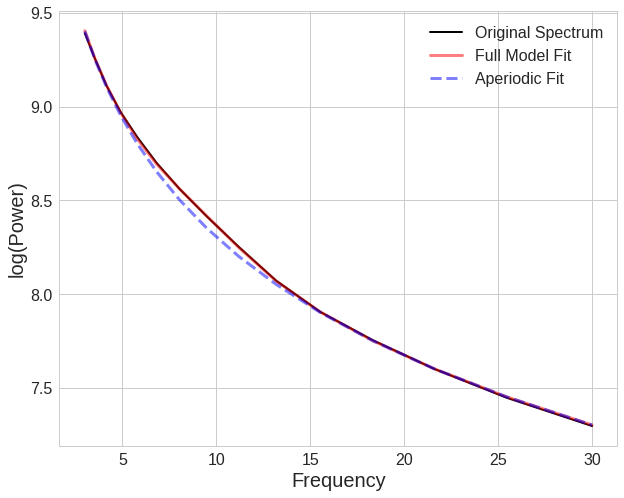

In [204]:
fm.report()

**Exercise:**

1. Play around with the FOOOF parameters, without changing the underlying spectrum. What happens if you change the range of frequencies to fit? What about changing the maximum number of peaks or maximum peak height?
2. Try fitting FOOOF separately for the spectrum corresponding to each word event. Compare the average aperiodic fit for recalled vs. not recalled words. 

### Parametric approaches to modeling

As discussed above, FOOOF is quite explicitly a *parametric* method. That is to say, there is a very specific model of neural power spectra (a 1/f background combined with gaussian peaks) which defines a number of parameters that need to be fitted. 

Why this is good:
- Parametric models are great because they do a fantastic job of precisely what they are designed to do - fit the data! 
- Importantly, as well, parametric models make data easily interpretable because our fit tells us what parameters in our data are changing and how.

The main drawbacks of parametric methods are:
- They explicitly expect data to conform to a very specific model. If they do not, that model is no longer interpretable. This is not entirely unique to parametric methods (lots of methods and models make assumptions which can be violated), and a *good* thing about a method like FOOOF is that you can directly test goodness of fit. Be careful, though, as improper tuning or noisy / unexpected data might result in parametric fits that *look* good but would lead you to an incorrect interpretation.
- Parametric models require the user / analyst to understand the model quite well, so that they can tune the model correctly. Data analysis is complicated and error-prone in general, and it is very easy to mess up an analysis by specifying inappropriate parameters.

Next, let's look at a different method which is non-parametric.

## Irregular Resampling Auto-Spectral Analysis (IRASA)

Developed in 2016 by two electrical engineers at Purdue, IRASA is a very mathematical approach to this problem. Unlike the parametric modelling approach, with IRASA we expect to analytically extract **exactly** the background spectrum. In practice, this does not work perfectly because the data are noisy and do not necessarily conform to an explicit assumption that the background spectrum is a power law distribution.

Check out the full paper [here](https://pubmed.ncbi.nlm.nih.gov/26318848/) if you're interested in the nitty gritty details

We've already learned to think about the power spectrum as being a sum of two components: an **aperiodic** background spectrum and **periodic** oscillations. IRASA moves forward with the same assumption, but with slightly different terminology. For the purposes of this method, we will talk about the $1/f$ background as the **fractal** spectrum as opposed to the **oscillatory** spectrum.

We have:
$$y(t)= f(t) + x(t)$$

where $y(t)$ is the mixed spectrum, $f(t)$ is the fractal spectrum, and $x(t)$ is the oscillatory spectrum.

#### So, what's a fractal?

<img src="https://media3.giphy.com/media/GLF8IKQ1Fvws3BzQ9v/giphy.gif?cid=ecf05e471zcps3bwmzd950m5w86uv5r4fdx1yqc80c2g7flg&rid=giphy.gif&ct=g" alt="fractal" width="200" align="left">
<br clear="left">

Fractals are mathematical objects which are **scale free**, meaning that if you zoom in or out (as in the image above), the structure repeats at all scales.

As it turns out, **power law distributions - like our $1/f$ background - are fractals!**

#### Why do we care about fractals?

Fractals, as mentioned above, are scale free - more formally, they are affine self-similar, and accordingly they have special properties under resampling.

Specifically:

$$f_h(t) \triangleq h^Hf(t)$$
This means that the statistical distribution of fractals are scaled, but otherwise unchanged, under resampling. 
$$F_h(\omega) = h^HF(\omega)$$
Even more importantly the Fourier transform of a resampled fractal is scaled, but otherwise exactly the same, under resampling!

Note:
- **f** : the fractal time series. 
- **F** : the Fourier transform of the original time series. The transform converts from the time ($t$) to the frequency ($\omega$) domain
- **h** : the resampling factor. h = 2.0 means twice as many samples as the original timeseries. h = 0.5 
- **H** : something called the Hurst exponent. Not really worth getting into here, but it has to do with the amount of autocorrelation in the time series. 
_ _ _ _
##### A clever trick!
Now what if we both upsample and downsample?

Upsample: $F_2(t) = 2^HF(t)$ <br>
Downsample: $F_{\frac{1}{2}}(t) = (\frac{1}{2})^HF(t)$

*I'm fudging the math a bit here by skipping the step of computing the autopower spectrum from the Fourier Transform - see the paper if you want the real deal*

Geometric Mean: $\sqrt{F_{\frac{1}{2}}(t)F_2(t)} =\sqrt{(\frac{1}{2})^H*2^HF^2(t)} = F(t)$

The geometric mean of the Fourier Transforms of up- and downsampled fractals is **exactly** the same as the Fourier Transform of the original signal!

This property, however applies **only** to the fractal background and **not** to the periodic/oscillatory component!
_ _ _ _
##### How does resampling work?
In the schematic below, you can see how repeatedly resampling causes an oscillation to shift in the frequency spectrum. 

To understand this, consider the following example:

Imagine you're trying to cross a river by hopping across on stones.
We start with 20 stones, and you can only hop one stone at a time

o o o o o o o o o o o o o o o o o o o o

How many hops does it take to cross the river? <br>
The answer: 20 hops / river (analogous to the frequency of an oscillation, in cycles / second)

Now, what if we remove half the stones? (Equivalent to removing half the samples in a timeseries by downsampling, with $h=\frac{1}{2}$)

o &nbsp;&nbsp; o &nbsp;&nbsp; o &nbsp;&nbsp; o &nbsp;&nbsp; o &nbsp;&nbsp; o &nbsp;&nbsp; o &nbsp;&nbsp; o &nbsp;&nbsp; o &nbsp;&nbsp; o  

You're still crossing the same river, and it's width has not changed - but now we would measure the river-crossing rate as 10 hops / river !!! That's *twice* as fast!

This is pretty much what happens when you resample timeseries data before doing a power decomposition - without properly accounting for the sampling rate, rhythmic patterns appear to happen more or less quickly than before resampling! For example, an 8 Hz oscillation samples at 1000Hz would look like a 16Hz oscillation when resampled with $h=\frac{1}{2}$
_ _ _ _

We take advantage of this by taking a median across the resampling factors - the fractal spectrum is the only constant as the oscillatory peaks move around, and so we get out **exactly** the fractal component.

![irasa](https://www.ncbi.nlm.nih.gov/pmc/articles/instance/4706469/bin/nihms719584f1.jpg)

Consider the following example of how this median, and it's robustness to outliers, can isolate the fractal signal.

We'll look at multiple arrays, representing spectra, with a moving "oscillation" - a massive peak of 1000 amidst a bunch of integer baseline values. 

In [183]:
# here's our baseline "spectrum", without any peaks
base = [5, 3, 4, 4, 2]

# now let's add a peak that shifts around
osc1 = [10000, 3, 4, 4, 2]
osc2 = [5, 10000, 4, 4, 2]
osc3 = [5, 3, 10000, 4, 2]
osc4 = [5, 3, 4, 10000, 2]
osc5 = [5, 3, 4, 4, 10000]

full_set = np.stack([base, osc1, osc2, osc3, osc4, osc5])
np.median(full_set, 0)

array([5., 3., 4., 4., 2.])

Voila! We get our baseline set back unperturbed by the outlying peaks.

Now, getting the oscillations from an EEG signal is as simple as subtracting the fractal spectrum from the mixed spectrum! 

So...

#### Summary of IRASA
- We treat the EEG as a combination of fractal and oscillatory components
- We repeatedly resample the original signal and compute the Fourier Transform / autopower spectra 
- We take the geometric mean of upsampled and downsampled power to remove scaling factors
- We take the median over resampling factor to isolate the fractal component
- We subtract the fractal component from the mixed autopower spectrum to obtain the oscillatory component. 

**It's important to note that FOOOF and IRASA expect different inputs. FOOOF is a modelling algorithm that fits a pre-computed power spectrum. IRASA directly computes the power decomposition from an EEG timeseries.** 

In [113]:
IRASA?

Init signature:
IRASA(sig, freqs=None, samplerate=1000, hset=array([1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 ]), flag_filter=1, flag_detrend=1)
Docstring:     
Irregular Resampling Auto Spectral Analysis.
Separates 1/f fractal component from oscillatory component.
Init docstring:
Parameters
__________

sig - timeseries data (last axis (axis = -1) must be time/samples)
freqs - frequencies to be included in power spectrum (1D array)
samplerate - sample rate in Hz
hset - array of resampling factors (>1)
flag_filter  - 1 or 0 (default 1): 1 means filtering before downsampling to avoid aliasing.
flag_detrend - 1 or 0 (default 1): 1 means detrending data before fft

Returns
__________
IRASA class instance
File:           ~/src/irasa/irasa/IRASA.py
Type:           type


**VERY IMPORTANT: note that the method assumes that time is the last axis, and will not work properly if this assumption is not satisfied!**

Initialize and IRASA object by entering the EEG and a frequency range for the desired spectrum

In [205]:
freqs = np.logspace(np.log10(3), np.log10(30), 15)
irasa = IRASA(eeg, freqs=freqs, samplerate=eeg.samplerate.values)

Removing linear trend
Filtering to avoid aliasing
Computing fractal PSD
Time elapsed for FFT: 6.3529 s


Use the built-in plotting methods to visualize the power spectrum and compare the original mixed signal to the separated fractal component. This fractal component should be linear in log-log coordinates.

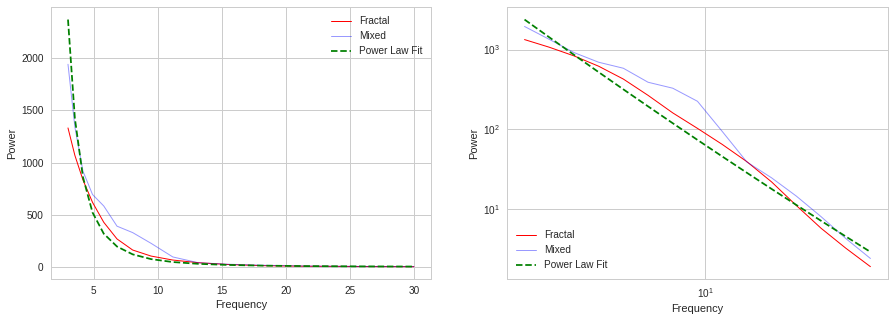

In [206]:
plt.figure(figsize=(15,5))
plt.subplot(121)
irasa.psdplot(fit=True)
plt.subplot(122)
irasa.loglogplot(fit=True)

Plot the oscillatory signal, which is equal to the difference of the mixed and fractal signals.

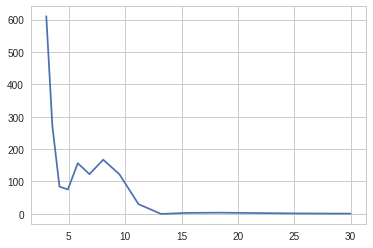

In [207]:
irasa.plot_oscillatory()

To work with the data more directly and create custom analyses, access the IRASA object's attributes.  
Important Attributes:  
**.freqs** - frequency values at which power was evaluated  
**.mixed** - PSD of the mixed signal contianing both fractal and oscillatory components  
**.fractal** - separated fractal component of the PSD

The PSD of the oscillatory component can be obtained indirectly, by subtracting .fractal from .mixed. Here we'll log transform the spectra in order to normalize the data a bit (*before* taking the difference, since we can't log negative numbers)

In [208]:
osc = np.log10(irasa.mixed) - np.log10(irasa.fractal)

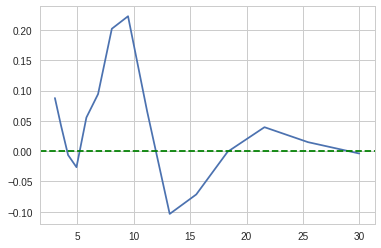

In [209]:
plt.plot(irasa.freqs, osc.mean(0))
plt.axhline(0, c='g', ls = '--')

For example, we can use boolean indexing to separate IRASA by recall performance

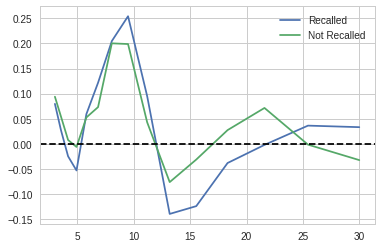

In [210]:
rec_mask = word_evs.recalled.astype(bool).values
plt.plot(irasa.freqs, osc[rec_mask].mean(0), label='Recalled')
plt.plot(irasa.freqs, osc[~rec_mask].mean(0), label='Not Recalled')
plt.axhline(0, c='k', linestyle='--')
plt.legend()

Now, let's compare this to a more traditional PSD. Let's compute a morlet wavelet decomposition and compare the recalled and not recalled powers:

CPP total time wavelet loop:  0.28945159912109375


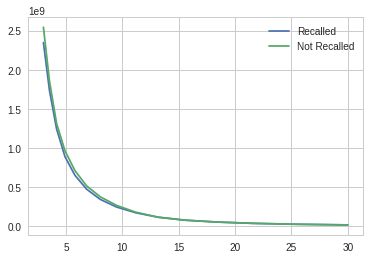

In [167]:
from ptsa.data.filters import MorletWaveletFilter
eeg.add_mirror_buffer(.5)
pows, _ = MorletWaveletFilter(freqs).filter(eeg)
pows.remove_buffer(.5)
log_pows = np.log10(pows.mean('time').values)
plt.plot(freqs, pows.mean('time').values[:, rec_mask].mean(1), label='Recalled')
plt.plot(freqs, pows.mean('time').values[:, ~rec_mask].mean(1), label='Not Recalled')
plt.legend()

This is way less informative than IRASA! We're not interested in the pink noise background as much as we are interested in the oscillations that deviate from it. IRASA helps us analyze these oscillations by separating them from the "fractal" pink noise component.

#### Fitting the fractal component

The plotting method above fit the fractal component to a 1/f function. You can also do this directly, and access the fit parameters and values. This can be useful if you want to evaluate the nature of the background spectrum or how it changes between conditions (i.e. spectral tilt).

In [168]:
p, plaw = irasa.plaw_fit()

Fit parameters in descending order, along the first axis. Subsequent axes are events (and/or channels)

In [169]:
print("Slopes: ", p[0, :10])
print("Intercepts: ", p[1, :10])

Slopes:  [-2.11222795 -2.9515978  -2.18911457 -2.51991879 -3.09140605 -2.50799368
 -2.58277612 -2.54838319 -2.9669614  -2.88201402]
Intercepts:  [3.04176739 4.97944979 3.61141617 4.11260768 5.01545604 4.34056921
 4.35951506 4.512346   4.91974894 4.88984287]


We can plot the expected power law spectrum itself

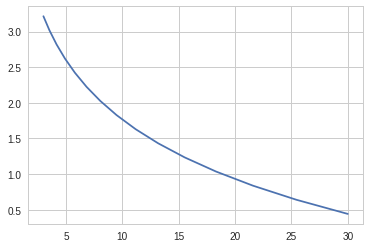

In [212]:
plt.plot(irasa.freqs, np.log10(plaw).mean(0))

The fit parameters and fitted spectrum can also be accessed with the .fit_params and .fit attributes, respectively.

**Exercise:**
1. Try changing the hset of our IRASA class. $h$ has to be greater than 1, and keep in mind that the more resampling factors you have, the longer the method will take to run (since it requires computing additional Fourier transforms for the upsampled and downsampled timeseries). What effect does this have on your estimation of the fractal and oscillatory spectra?
    - This might seem like a parameter, but we claimed IRASA is a non-parametric method. Both are sort of true! This is indeed a computational parameter that affects our output, but it actually has nothing to do with our model or any kind of fitting. 
2. Compare the output of FOOOF and IRASA for the same data. How are they similar? How are they different?

**Extended reading and resources**
- Oscillation methods project by Tom and others: https://oscillationmethods.github.io/docs/viz.html
- BOSC (Jeremy Caplan + Kahana Lab): https://www.sciencedirect.com/science/article/pii/S1053811910011614?via%3Dihub
- eBOSC: https://github.com/jkosciessa/eBOSC
- MODAL (developed by Watrous et al): https://github.com/andrew-j-watrous/MODAL